<a href="https://colab.research.google.com/github/Josephjiao7/GeoGAT/blob/main/GeoGAT_E_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
import torch.nn.functional as F
from torch_geometric.nn import GATConv, TopKPooling, global_mean_pool
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.nn import GATConv
import torch_geometric
from pysal.lib import weights
from scipy import sparse
from scipy.sparse import eye
import matplotlib.pyplot as plt
import random
# from mgwr.gwr import GWR
# from mgwr.sel_bw import Sel_BW

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [18]:
data = gpd.read_file("/data/election.geojson")
data = data.to_crs("+proj=lcc +lat_1=33 +lat_2=45 +lat_0=39 +lon_0=-96 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")

# input labels
y = data['pct_gop_16'].values

# input independent variables
X_vars = ['AGE135214','AGE775214','POP815213',
          'SEX255214','RHI125214','POP715213','EDU635213','EDU685213',
          'LFE305213','HSG445213']
X = data[X_vars].values

X_names = ['AGE_U5','AGE_O65','LO5', 'Female_pct','White_pct','LH1','EDU_H25','EDU_B25','MTW_16','HR']

data['X'] = data['geometry'].centroid.x
data['Y'] = data['geometry'].centroid.y
coords = data[['X', 'Y']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

features = torch.FloatTensor(X_scaled).to(device)
labels = torch.FloatTensor(y).to(device)

In [19]:
def make_sym_matrix_boolean_sum(matrix):
    return matrix + matrix.T

def renormalized_trick_mx(matrix):
    I = np.eye(matrix.shape[0])
    D = np.diag(np.sum(matrix, axis=1))
    D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diagonal(D)))
    return D_inv_sqrt @ (matrix + I) @ D_inv_sqrt

def renormalized_trick_laplacian(matrix):
    I = np.eye(matrix.shape[0])
    return I - matrix

def calculate_weighted_similarity(X, sigma_values, weights):
    u = X[:, np.newaxis, :]
    v = X[np.newaxis, :, :]
    sq_diff = (u - v) ** 2
    E_i = np.exp(-((sq_diff) / (2 * (sigma_values))))
    weighted_similarity = np.average(E_i, axis=2, weights=weights)
    return weighted_similarity

# Identify the neigborhoods of observations, bandwith calculated by GWR, Queen rule, Rook rule, KNN
# gwr_selector = Sel_BW(coords, y.reshape(-1,1), X_scaled)
# gwr_k = gwr_selector.search(search_method='golden_section', criterion='AICc')
# knn=weights.KNN.from_dataframe(data,geom_col='geometry',k=gwr_k)
knn=weights.KNN.from_dataframe(data,geom_col='geometry',k=10)
A_20nn_sym = make_sym_matrix_boolean_sum(knn.full()[0])
A_tilde_20nn_sym = renormalized_trick_mx(A_20nn_sym)

# Calculate spatial similarity as edge weights of GAT model
# sigma_values = np.var(X, axis=0)
sigma_values = X.std(0) * 0.5
weight_s = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
similarity_matrix1 = calculate_weighted_similarity(X, sigma_values, weight_s)

weighted_adj = np.zeros_like(A_20nn_sym, dtype=np.float32)
for i in range(A_20nn_sym.shape[0]):
    neighbors = np.where(A_20nn_sym[i] > 0)[0]
    for neighbor in neighbors:
        weighted_adj[i, neighbor] = similarity_matrix1[i, neighbor]

weighted_adj_tensor = torch.FloatTensor(weighted_adj).to(device)

In [20]:
edge_index, edge_weight = torch_geometric.utils.dense_to_sparse(weighted_adj_tensor)
edge_index = edge_index.to(device)
edge_weight = edge_weight.to(device)

In [21]:
class CausalGAT(nn.Module):
    def __init__(self, f_in, hidden=40, heads=20):
        super().__init__()
        self.gat_c = GATConv(f_in, hidden, heads=heads, concat=True, edge_dim=1)
        self.gat_s = GATConv(f_in, hidden, heads=heads, concat=True, edge_dim=1)

        out_dim = hidden * heads
        self.w_c   = nn.Linear(out_dim, f_in)
        self.w_s   = nn.Linear(out_dim, f_in)
        self.pred  = nn.Linear(out_dim, 1)

    def forward(self, x, ei, ew):
        h_c = F.elu(self.gat_c(x, ei, ew))      # [N , out_dim]
        h_s = F.elu(self.gat_s(x, ei, ew))

        w_c = self.w_c(h_c)                    # [N , F]
        w_s = self.w_s(h_s)                    # [N , F]

        y_c = (w_c * x).sum(1)                 # [N]

        y_s = (w_s * x).sum(1)                 # [N]
        h_s_perm = h_s[torch.randperm(h_s.size(0))]
        y_hat    = self.pred(h_c + h_s_perm).squeeze()   # [N]

        return y_hat, y_c, y_s, w_c


In [22]:
def loss_fn(y_hat, y_c, y_s, y,
            λ1=1.0, λ2=0.5, λ3=0.5):
    mse_pred = F.mse_loss(y_hat, y)
    causal_l = F.mse_loss(y_c,  y)
    trivial_l= F.mse_loss(y_s,  torch.zeros_like(y))
    back_l   = F.mse_loss(y_hat, y)
    return mse_pred + λ1*causal_l + λ2*trivial_l + λ3*back_l

In [28]:
def train_model(model, features, edge_index, edge_weight, labels,
                epochs=2000, lr=1e-3, weight_decay=1e-5):

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for ep in range(epochs):
        model.train()
        opt.zero_grad()
        y_hat, y_c, y_s, w_c = model(features, edge_index, edge_weight)

        loss = loss_fn(y_hat, y_c, y_s, labels,
                       λ1=1.0, λ2=0.5, λ3=0.5)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        if (ep+1) % 100 == 0:
            print(f'Epoch {ep+1:4d} | total={loss.item():.4f}')

    return model

causal_model = CausalGAT(f_in = features.shape[1],hidden =64, heads=20).to(device)
trained_causal_model = train_model(causal_model, features, edge_index, edge_weight, labels, epochs=3000, lr=1e-3)

Epoch  100 | total=0.0862
Epoch  200 | total=0.0496
Epoch  300 | total=0.0372
Epoch  400 | total=0.0321
Epoch  500 | total=0.0323
Epoch  600 | total=0.0247
Epoch  700 | total=0.0234
Epoch  800 | total=0.0228
Epoch  900 | total=0.0197
Epoch 1000 | total=0.0186
Epoch 1100 | total=0.0186
Epoch 1200 | total=0.0171
Epoch 1300 | total=0.0165
Epoch 1400 | total=0.0167
Epoch 1500 | total=0.0151
Epoch 1600 | total=0.0164
Epoch 1700 | total=0.0149
Epoch 1800 | total=0.0140
Epoch 1900 | total=0.0142
Epoch 2000 | total=0.0151
Epoch 2100 | total=0.0132
Epoch 2200 | total=0.0135
Epoch 2300 | total=0.0127
Epoch 2400 | total=0.0141
Epoch 2500 | total=0.0120
Epoch 2600 | total=0.0122
Epoch 2700 | total=0.0116
Epoch 2800 | total=0.0114
Epoch 2900 | total=0.0111
Epoch 3000 | total=0.0112


In [29]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def evaluate_causal_model(model, features, edge_index, edge_weight, labels):
    model.eval()
    with torch.no_grad():
        y_hat, *_ = model(features, edge_index, edge_weight)
        y_hat = y_hat.squeeze()

        y_true = labels.cpu().numpy()
        y_pred = y_hat.cpu().numpy()
        mape   = mean_absolute_percentage_error(y_true, y_pred)

        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        r2     = 1 - ss_res / ss_tot

    return y_hat, mape, r2

causal_predictions, mape, r2 = evaluate_causal_model(trained_causal_model, features, edge_index, edge_weight, labels)
print(f'Test MAPE: {mape:.4f}%')
print(f'Test R²: {r2:.4f}')

Test MAPE: 8.0503%
Test R²: 0.8726


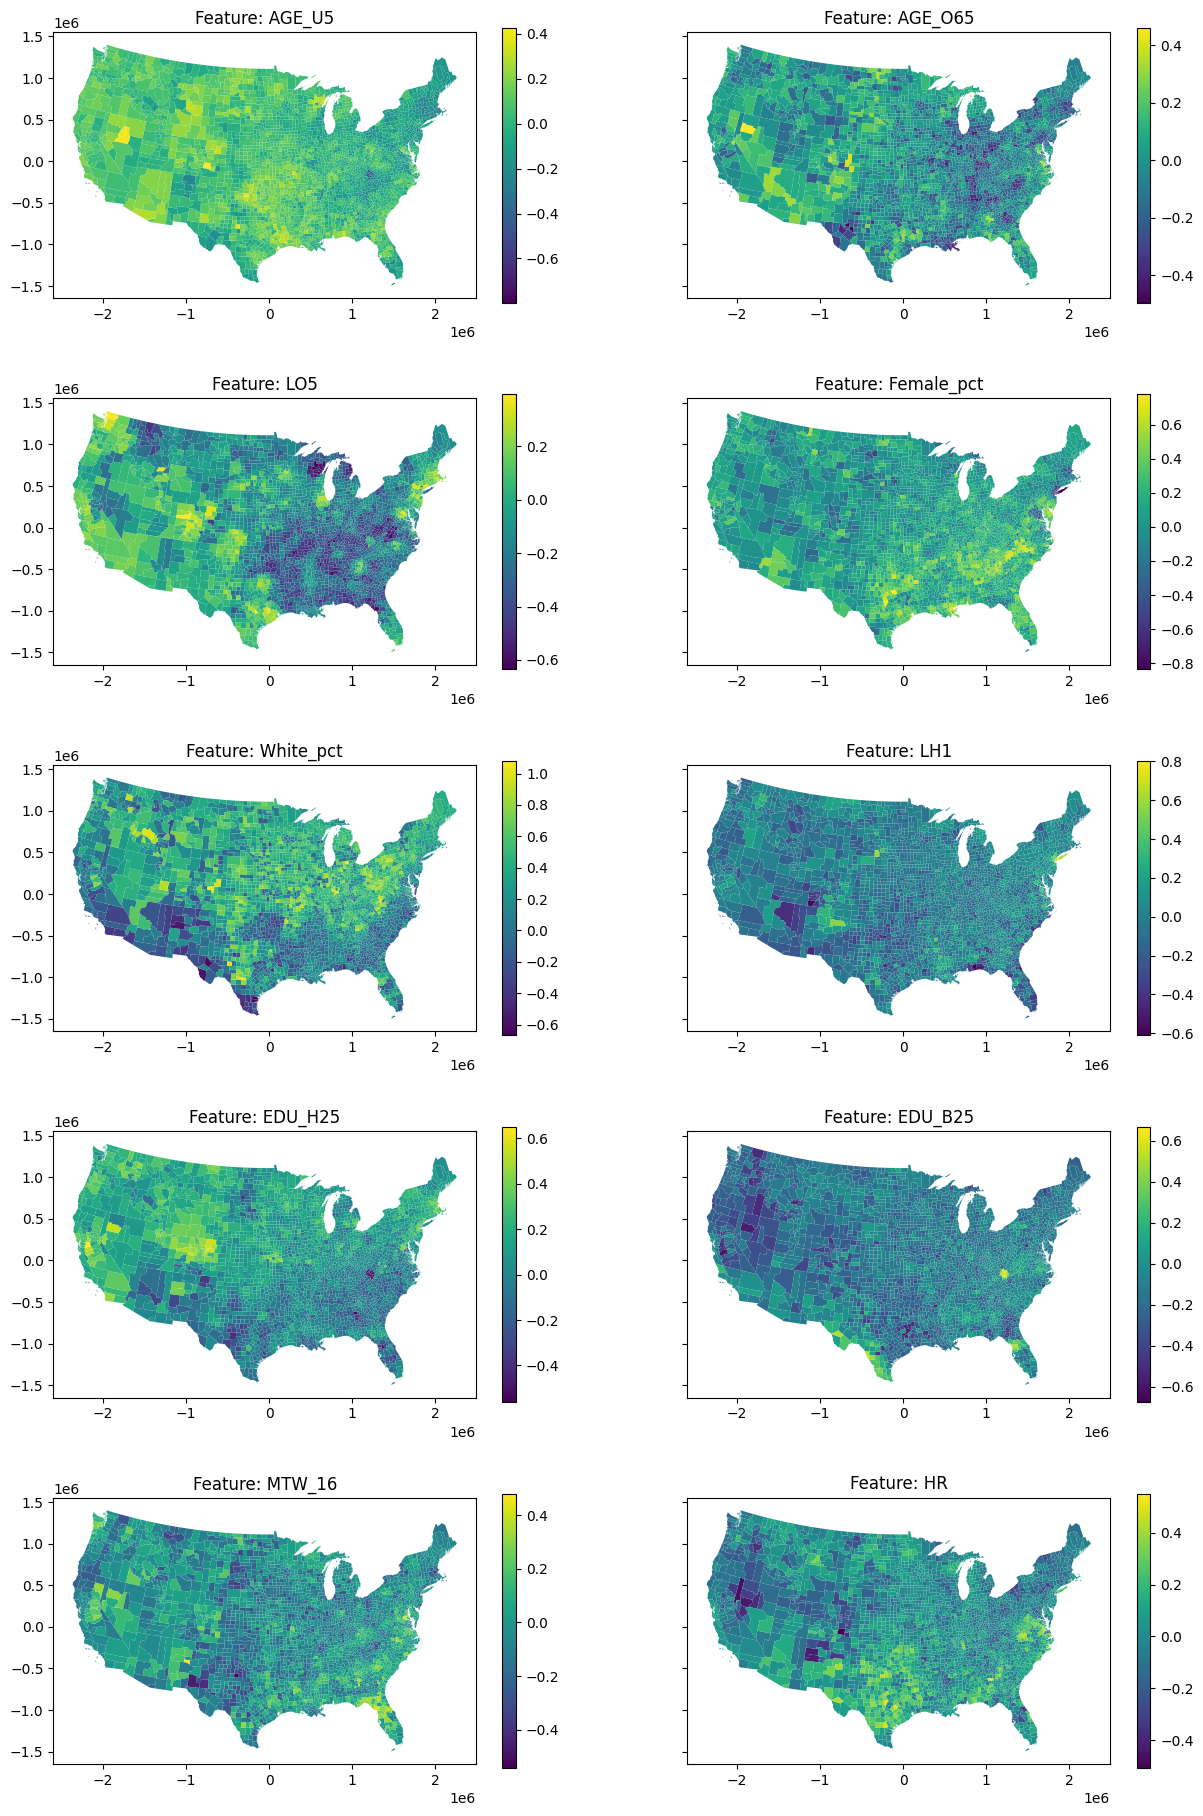

In [ ]:
def plot_causal_attention_maps(gdf, causal_attention_matrix, feature_names):
    num_features = causal_attention_matrix.shape[1]

    fig, axes = plt.subplots(5, 2, figsize=(15, 23), sharey=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_features:
            gdf['attention_score'] = causal_attention_matrix[:, i]

            gdf.plot(column='attention_score', ax=ax, legend=True, cmap='viridis', legend_kwds={'orientation': 'vertical','shrink': 0.9})
            ax.set_title(f'Feature: {feature_names[i]}')
        else:
            fig.delaxes(ax)

    # plt.tight_layout()
    # plt.show()
trained_causal_model.eval()
with torch.no_grad():
    _, _, _, causal_feat = trained_causal_model(
        features, edge_index, edge_weight)

plot_causal_attention_maps(
    data,
    causal_feat.cpu().numpy(),
    X_names
)
plt.savefig('/picture/lcsm_e2.jpg', dpi=600)